# KNN Implementation on scaled reduced dataset with PCA

In [ ]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [ ]:
df_pca = pd.read_csv('../../DimensionalityReductionData/PCA.csv')

In [ ]:
df_scaled_copy = df_scaled[['averageRating']]
df_scaled = df_pca
df_scaled['averageRating'] = df_scaled_copy['averageRating']
del df_scaled_copy

In [ ]:
df_scaled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,averageRating
0,0.073496,0.581127,-0.306591,-0.458056,-0.326569,-0.432148,0.285284,0.120601,-0.382754,-0.220533,-0.173304,-0.237751,-0.278836,-0.255647,-0.126061,-0.138865,0.025244,-0.275903,1.0
1,-0.674232,0.297946,0.299652,-0.247368,0.350443,0.430246,-0.511015,0.180800,-0.014047,-0.185657,0.105798,-0.102234,-0.070109,0.002179,0.138295,0.010346,0.088212,0.026563,0.0
2,-0.602295,-0.213501,-0.367282,0.446712,-0.379628,0.201488,0.226710,0.332919,-0.030743,-0.052051,0.197735,-0.145173,0.140576,0.062989,-0.117784,0.002612,-0.020744,0.096351,1.0
3,-0.308130,-0.303248,-0.099318,-0.550675,0.147219,-0.608601,-0.045995,0.519164,0.094052,-0.122320,0.207885,-0.691366,-0.326278,-0.371787,-0.147163,0.056105,-0.315359,-0.211726,0.0
4,-0.548584,-0.107256,0.301375,-0.134301,-0.221954,-0.139591,-0.175504,-0.064892,0.043229,-0.271392,0.054528,-0.095603,-0.064297,0.011336,0.107454,-0.038404,0.111143,0.080739,0.0


In [ ]:
df_scaled_sample = df_scaled

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=23
)

In [ ]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# y_test has 1 Nan value - I removed it from y_test and removed a value from predictions to match in length
y_test = y_test[~np.isnan(y_test)]
predictions = model.predict(X_test)
predictions = predictions[1:]
print("Accuracy:", accuracy_score(y_test, predictions, ))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.6094635121626124
F1 score: [0.62242268 0.59558316]


In [ ]:
param_grid = {
    'n_neighbors': [3, 7, 15],
    'p': [1, 2, 3, 4.3],
    'n_jobs': [-1, 1]
}

model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The parameters with the highest score:  {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}


In [ ]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                         params  mean_test_score
22     {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}         0.627239
10    {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}         0.627239
21     {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}         0.624991
9     {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}         0.624991
23   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}         0.624407
11  {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}         0.624407
8     {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}         0.622158
20     {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}         0.622158
18      {'n_jobs': 1, 'n_neighbors': 7, 'p': 3}         0.617493
6      {'n_jobs': -1, 'n_neighbors': 7, 'p': 3}         0.617493


Metrics for KNN-PCA-GS-CV1:
Accuracy: 0.6165
Weighted F1: 0.6160
Weighted Precision: 0.6162
Weighted Recall: 0.6165
Macro-Averaged Precision: 0.6160
Macro-Averaged Recall: 0.6154
F1: [0.63587472 0.59486096]
Precision: [0.62190594 0.6101083 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.62      0.65      0.64      1545
     Class 1       0.61      0.58      0.59      1456

    accuracy                           0.62      3001
   macro avg       0.62      0.62      0.62      3001
weighted avg       0.62      0.62      0.62      3001

Confusion Matrix


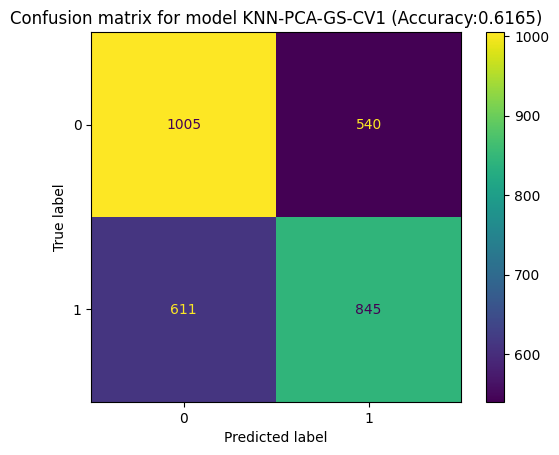

In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
predictions = predictions[1:]
_ = calculate_metrics('KNN-PCA-GS-CV1', y_test, predictions)

In [ ]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  predictions = predictions[1:]
  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))

Parameters from place:  0   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6164611796067977
Parameters from place:  1   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6164611796067977
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.623125624791736
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.623125624791736
Parameters from place:  4   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6127957347550816
Parameters from place:  5   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6127957347550816
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6197934021992669
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6197934021992669
Parameters from place:  8   {'n_jo

In [ ]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [ ]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.623125624791736
{'n_jobs': 1, 'n_neighbors': 15, 'p': 2}


In [ ]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6816326530612244
Parameters from place:  1   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6816326530612244
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.685381091211995
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.685381091211995
Parameters from place:  4   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6803831736776343
Parameters from place:  5   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6803831736776343
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6860474802165765
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6860474802165765
Parameters from place:  8   {'n_jo